<a href="https://colab.research.google.com/github/MarcusBranch/Vis-oComputacional/blob/main/Kvasir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import glob
from glob import glob
import tensorflow as tf
import cv2
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import matplotlib.pyplot as plt
import albumentations as alb
from albumentations import CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [431]:
batch_size = 8
path = '/content/drive/MyDrive/Kvasir1000'
# img_path = '/content/drive/MyDrive/Kvasir880/Kvasir_SEG_Training_880/image'
# mask_path = '/content/drive/MyDrive/Kvasir880/Kvasir_SEG_Training_880/mask'

In [432]:
def load_data(path):
  #pega o caminho do conjunto de dados e fornece uma lista de imagens e caminhos de máscaras.
  images = sorted(glob(os.path.join(path, "images/*")))
  masks = sorted(glob(os.path.join(path, "masks/*"))) 
  return images, masks

In [433]:
def create_dir(path):
  #pega um caminho e cria um diretório vazio
  if not os.path.exists(path):
    os.makedirs(path)

In [434]:
def augment_data(images, masks, save_path, augment=True):
  H = 320
  W = 320

  for x, y in tqdm(zip(images, masks), total=len(images)):
    # percorre a lista de imagens e masks e o
    # o tqdm exibe o progresso do loop.
    name = x.split("/")[-1].split(".")
    'Extraindo o nome e extensão dos arquivos'
    image_name = name[0]
    image_extn = name[1]
    name = y.split("/")[-1].split(".")
    mask_name = name[0]
    mask_extn = name[1]

    'Lendo as imagens e as masks'
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = cv2.imread(y, cv2.IMREAD_COLOR)

    'Definindo as técnicas de augmentation' # p = 1 é a probabilidade de aplicar o augment (ou seja, 100%)
    if augment == True:
      aug = CenterCrop(H, W, p=1.0)
      augmented = aug(image=x, mask=y)
      x1 = augmented["image"]
      y1 = augmented["mask"]

      aug = RandomRotate90(p=1.0)
      augmented = aug(image=x, mask=y)
      x2 = augmented['image']
      y2 = augmented['mask']

      aug = GridDistortion(p=1.0)
      augmented = aug(image=x, mask=y)
      x3 = augmented['image']
      y3 = augmented['mask']

      aug = HorizontalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x4 = augmented['image']
      y4 = augmented['mask']

      aug = VerticalFlip(p=1.0)
      augmented = aug(image=x, mask=y)
      x5 = augmented['image']
      y5 = augmented['mask']

      save_images = [x, x1, x2, x3, x4, x5]
      save_masks =  [y, y1, y2, y3, y4, y5] # salvando imagens e masks originais e geradas

      idx = 0
      for i, m in zip(save_images, save_masks):
        # percorrendo o vetor que armazena as imagens e masks
        i = cv2.resize(i, (W, H))             # redimensionando para o tamanho desejado e setado anteriormente
        m = cv2.resize(m, (W, H))

        if len(images) == 1:
          img_name = f"{image_name}.{image_extn}"  #nomeia as imagens e masks com nome e formato
          msk_name = f"{mask_name}.{mask_extn}"

        else:
          img_name = f"{image_name}_{idx}.{image_extn}"
          msk_name = f"{mask_name}_{idx}.{mask_extn}"

          image_path = os.path.join(save_path, "images/", img_name)  
          mask_path = os.path.join(save_path, "masks/", msk_name) #salva as imagens e masks 

          cv2.imwrite(image_path, i)  #indica o caminho que vai salvar
          cv2.imwrite(mask_path, m)

          idx += 1

In [435]:
image, mask = load_data(path) # apenas verificando e confirmando a quantidade 
print(f"Quantidade de Imagens: {len(image)} - Quantidade de Masks: {len(mask)}")

Quantidade de Imagens: 1000 - Quantidade de Masks: 1000


In [436]:
create_dir("new_data/images")
create_dir("new_data/masks") #criando as pastas que vão salvar os dados aumentados

In [437]:
augment_data(image, mask, "new_data", augment=True) # aplica a função augment_data definida

100%|██████████| 1000/1000 [01:44<00:00,  9.55it/s]


In [438]:
image, mask = load_data("new_data/")
print('Nº de Imagens após augmentation: ', len(image))
print('Nº de Masks após augmentation: ', len(mask)) # carregando os dados aumentados e verificando a quantidade

Nº de Imagens após augmentation:  6000
Nº de Masks após augmentation:  6000


In [439]:
path = "/content/new_data"

In [440]:
np.random.seed(42)
tf.random.set_seed(42)

In [441]:
im_size = 320
epochs = 30
batch_size = 8

In [442]:
def load_data(path, split=0.1): #pega o caminho, carrega imagens e masks e divide em treino, val e teste (70%, 15%, 15%)
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split*total_size)
    test_size = int(split*total_size)

    X_train, X_val = train_test_split(images, test_size=valid_size, random_state=42)
    y_train, y_val = train_test_split(masks, test_size=valid_size, random_state=42)

    X_train, X_test = train_test_split(X_train, test_size=test_size, random_state=42)
    y_train, y_test = train_test_split(y_train, test_size=test_size, random_state=42)

    return (X_train,y_train), (X_val,y_val), (X_test,y_test)


# from sklearn.model_selection import train_test_split
# def load_img_mask(X, y):
#     # 80% treino, 10% val, 10% teste
#     #img = img
#     #mask = mask
    
#     #size = len(img)
#     #val_size = int(split*size)
#     #test_size = int(split*size)
    
#     X_train, X_val, y_train, y_val = train_test_split(image, mask, test_size = 0.2, random_state = 42)
    
#     X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)
    
#     return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [443]:
def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  x = cv2.resize(x, (320,320))
  x = x/255
  return x

def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (320,320))
  x = x/255
  x = np.expand_dims(x, axis=-1) # para deixar no formato (H, W, 1)
  return x


  # aqui as duas funções carregam a imagem do caminho fornecido, redimensiona pra 224x224, normaliza os pixels
# dividindo por 255 e no fim retorna uma imagem colorida e a mask em preto e branco

In [444]:
def tf_parse(x, y):
  def _parse(x, y):
    x = read_image(x)
    y = read_mask(y)
    return x, y

  x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
  x.set_shape([320,320, 3])
  y.set_shape([320,320, 1])
  return x, y

def tf_dataset(x, y, batch):
  dataset = tf.data.Dataset.from_tensor_slices((x, y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.repeat()
  return dataset

# aqui é construído um pipeline de dados, a primeira função analisa uma única imagem e caminho da mask
# a segunda função cria um pipeline tf.data que obtém uma lista de imagens, o caminho das masks e o batch.

In [445]:
(X_train,y_train), (X_val,y_val), (X_test,y_test) = load_data(path)  # Verificando os 80% treino e 20% pra valid e teste

print("Dados de treinamento: ", len(X_train))
print("Dados de validação: ", len(X_val))
print("Dados de teste: ", len(X_test))

Dados de treinamento:  4800
Dados de validação:  600
Dados de teste:  600


In [446]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [447]:
dados_treino = tf_dataset(X_train, y_train, batch = batch_size)
dados_treino

<RepeatDataset shapes: ((None, 320, 320, 3), (None, 320, 320, 1)), types: (tf.float64, tf.float64)>

In [448]:
dados_val = tf_dataset(X_val,y_val, batch = batch_size)
dados_val

<RepeatDataset shapes: ((None, 320, 320, 3), (None, 320, 320, 1)), types: (tf.float64, tf.float64)>

In [449]:
dados_test = tf_dataset(X_test,y_test, batch = batch_size)
dados_test

<RepeatDataset shapes: ((None, 320, 320, 3), (None, 320, 320, 1)), types: (tf.float64, tf.float64)>

In [450]:
# def read_and_rgb(x):
#     x = cv2.imread(x)
#     return x

In [451]:
# # Apenas verificando as imagens e masks correspondentes

# fig = plt.figure(figsize=(12, 12))
# a = fig.add_subplot(1, 4, 1)
# imgplot = plt.imshow(X_train[0])

# a = fig.add_subplot(1, 4, 2)
# imgplot = plt.imshow(X_train[1])
# imgplot.set_clim(0.0, 0.7)

# # a = fig.add_subplot(1, 4, 3)
# # imgplot = plt.imshow(read_and_rgb(X_train[2]))
# # imgplot.set_clim(0.0, 1.4)

# # a = fig.add_subplot(1, 4, 4)
# # imgplot = plt.imshow(read_and_rgb(X_train[3]))
# # imgplot.set_clim(0.0, 2.1)

# fig = plt.figure(figsize=(12, 12))
# a = fig.add_subplot(1, 4, 1)
# imgplot = plt.imshow(y_train[0])

# a = fig.add_subplot(1, 4, 2)
# imgplot = plt.imshow(y_train[1])
# imgplot.set_clim(0.0, 0.7)

# # a = fig.add_subplot(1, 4, 3)
# # imgplot = plt.imshow(read_and_rgb(y_train[2]))
# # imgplot.set_clim(0.0, 1.4)

# # a = fig.add_subplot(1, 4, 4)
# # imgplot = plt.imshow(read_and_rgb(y_train[3]))
# # imgplot.set_clim(0.0, 1.4)

In [452]:
smooth = 1e-12
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def IoU(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection 
    x = (intersection + smooth) / (union + smooth)
    return x

In [454]:
metrics = [dice_coef, IoU]
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,min_lr=0.00001),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False),
    tf.keras.callbacks.TensorBoard()
]

In [455]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomHeight, RandomTranslation, RandomRotation, RandomZoom, RandomWidth
from keras.models import Sequential
data_augmentation = Sequential(
    [
     RandomFlip('horizontal'),
     RandomRotation(0.2),
     RandomFlip('vertical')
    ],
    name='data_augmentation',
)

In [456]:
# initial_learning_rate = 0.1
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=50,
#     decay_rate=0.96,
#     staircase=True)

# learning_rate = 0.1
# decay_rate = learning_rate / epochs
# momentum = 0.8

In [457]:
# Construindo o modelo
inputs = tf.keras.layers.Input((320,320,3))
# inputs_aug = data_augmentation(inputs)
#s = tf.keras.layers.Lambda(lambda x: x/255)(inputs) #converte cada pixel da imagem para um floating point pra dps multiplicar com os pesos que tbm sao floating points

# Contraction/Encoder path
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
#kernel_initializer é pra definir os valores iniciais dos pesos q serão atualizados, pois precisa começar de algum lugar
#padding = same é pra garantir a imagem de saída tenha as mesmas dimensões da imagem de entrada
# c1 = tf.keras.layers.Dropout(0.1)(c1) #elimina alguns valores inuteis entre as camadas pra evitar overfitting
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
#c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
# c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
#c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
# c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

# Expansive/Decoder path
u6 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
#c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
# c7 = tf.keras.layers.Dropout(0.1)(c7)
c7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
#c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
# c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
#outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(outputs)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.00001), loss= dice_loss, metrics= metrics)
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv2d_365 (Conv2D)             (None, 320, 320, 32) 896         input_20[0][0]                   
__________________________________________________________________________________________________
conv2d_366 (Conv2D)             (None, 320, 320, 32) 9248        conv2d_365[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_76 (MaxPooling2D) (None, 160, 160, 32) 0           conv2d_366[0][0]                 
___________________________________________________________________________________________

In [458]:
# tf.keras.utils.plot_model(model, show_shapes=True)

In [459]:
batch_size = 8
train_steps = len(X_train)/batch_size
valid_steps = len(X_val)/batch_size

In [460]:
results = model.fit(dados_treino, validation_data = dados_val, epochs=50, steps_per_epoch= train_steps, validation_steps = valid_steps, callbacks=callbacks)

Epoch 1/50
600/600 [==============================] - 160s 264ms/step - loss: 0.6693 - dice_coef: 0.3307 - IoU: 0.2028 - val_loss: 0.5490 - val_dice_coef: 0.4510 - val_IoU: 0.2958
Epoch 2/50
600/600 [==============================] - 157s 262ms/step - loss: 0.5492 - dice_coef: 0.4508 - IoU: 0.2959 - val_loss: 0.5008 - val_dice_coef: 0.4992 - val_IoU: 0.3373
Epoch 3/50
600/600 [==============================] - 157s 262ms/step - loss: 0.5177 - dice_coef: 0.4823 - IoU: 0.3232 - val_loss: 0.4951 - val_dice_coef: 0.5049 - val_IoU: 0.3422
Epoch 4/50
600/600 [==============================] - 157s 262ms/step - loss: 0.4915 - dice_coef: 0.5085 - IoU: 0.3462 - val_loss: 0.4833 - val_dice_coef: 0.5167 - val_IoU: 0.3535
Epoch 5/50
600/600 [==============================] - 157s 262ms/step - loss: 0.4799 - dice_coef: 0.5201 - IoU: 0.3571 - val_loss: 0.4661 - val_dice_coef: 0.5339 - val_IoU: 0.3696
Epoch 6/50
600/600 [==============================] - 158s 263ms/step - loss: 0.4601 - dice_coef: 0.

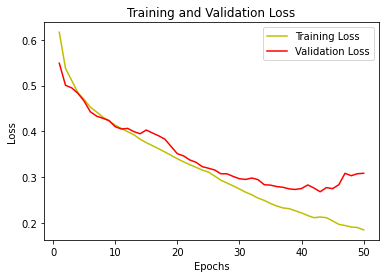

In [461]:
import matplotlib.pyplot as plt
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs,loss,'y',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

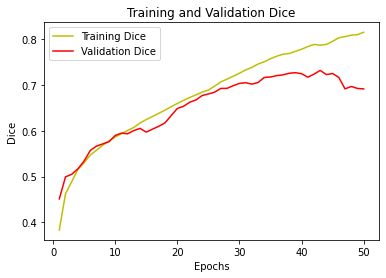

In [462]:
dic = results.history['dice_coef']
val_dic = results.history['val_dice_coef']
epochs = range(1, len(dic)+1)
plt.plot(epochs,dic,'y',label='Training Dice')
plt.plot(epochs,val_dic,'r',label='Validation Dice')
plt.title('Training and Validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

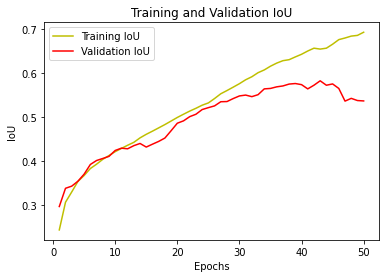

In [463]:
iou = results.history['IoU']
val_iou = results.history['val_IoU']
epochs = range(1, len(iou)+1)
plt.plot(epochs,iou,'y',label='Training IoU')
plt.plot(epochs,val_iou,'r',label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
# rec = results.history['recall']
# val_rec = results.history['val_recall']
# epochs3 = range(1, len(rec)+1)
# plt.plot(epochs3,rec,'b',label='Recall de Treino')
# plt.plot(epochs3,val_rec,'r',label='Recall de Validação')
# plt.title('Recall de Treino e Validação')
# plt.xlabel('Época')
# plt.ylabel('Recall')
# plt.legend()
# plt.show()

In [ ]:
# prec = results.history['precision']
# val_prec = results.history['val_precision']
# epochs4 = range(1, len(prec)+1)
# plt.plot(epochs4,prec,'b',label='Precision de Treino')
# plt.plot(epochs4,val_prec,'r',label='Precision de Validação')
# plt.title('Precision de Treino e Validação')
# plt.xlabel('Época')
# plt.ylabel('Precision')
# plt.legend()
# plt.show()

In [464]:
print('Coeficiente Dice de Treino:', model.evaluate(dados_treino, batch_size = 8, steps = train_steps)[1])
print('Coeficiente Dice de Validação:', model.evaluate(dados_val, batch_size = 8, steps = train_steps)[1])

600/600 [==============================] - 46s 76ms/step - loss: 0.2402 - dice_coef: 0.7598 - IoU: 0.6197
Coeficiente Dice de Treino: 0.7597906589508057
600/600 [==============================] - 45s 75ms/step - loss: 0.3086 - dice_coef: 0.6914 - IoU: 0.5365
Coeficiente Dice de Validação: 0.6913906931877136


In [465]:
print('IoU de Treino:', model.evaluate(dados_treino, batch_size = 16, steps = train_steps)[2])
print('IoU de Validação:', model.evaluate(dados_val, batch_size = 16, steps = train_steps)[2])

600/600 [==============================] - 45s 75ms/step - loss: 0.2402 - dice_coef: 0.7598 - IoU: 0.6197
IoU de Treino: 0.6197168827056885
600/600 [==============================] - 45s 75ms/step - loss: 0.3086 - dice_coef: 0.6914 - IoU: 0.5365
IoU de Validação: 0.5364779829978943


In [466]:
test_steps = len(X_test)/batch_size

model.evaluate(dados_test, batch_size = 8, steps = test_steps)

75/75 [==============================] - 6s 75ms/step - loss: 0.2998 - dice_coef: 0.7002 - IoU: 0.5457


[0.2998421788215637, 0.7001577019691467, 0.5456863045692444]

In [ ]:
# model.save('/content/drive/MyDrive/kvasir_1version.h5')

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/MyDrive/kvasir_1version.h5', compile = True)

In [ ]:
# img = cv2.imread(X_test[2])

In [ ]:
# test_img = cv2.imread('/content/drive/MyDrive/Kvasir880/images/cju8cdeazsm8h0801jxifmzur.png', cv2.IMREAD_GRAYSCALE)
# test_img = cv2.resize(test_img, (320,320))
# test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
# #plt.imshow(test_img, cmap='gray')
# test_img = np.expand_dims(test_img, axis=0)

In [ ]:
# pred = model.predict(test_img)
# plt.imsave('/content/drive/MyDrive/kvasir_PREDICT2.jpg', pred)

In [ ]:
# plt.imshow(pred, cmap='gray')

In [467]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [468]:
# def show_predictions(dataset=None, num=1):
#   if dataset:
#     for image, mask in dataset.take(num):
#       pred_mask = model.predict(image)
#       display([image[0], mask[0], create_mask(pred_mask)])
#   else:
#     display([sample_image, sample_mask,
#              create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [469]:
def read_img(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    #x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (320,320))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (320,320))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [470]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

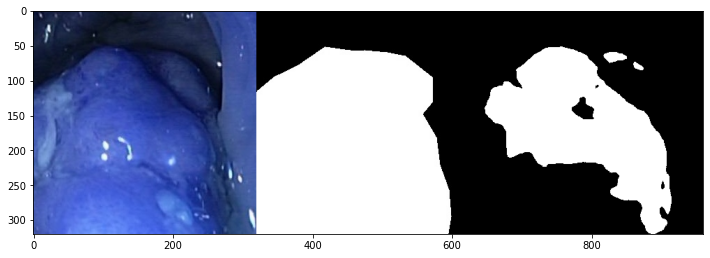

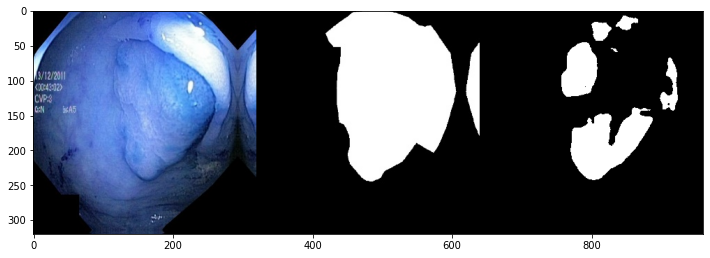

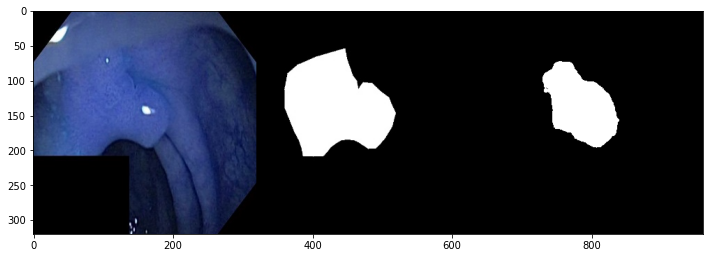

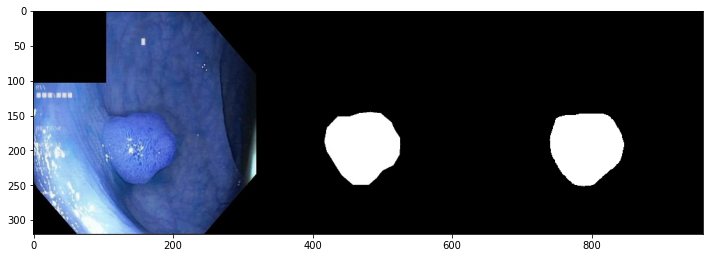

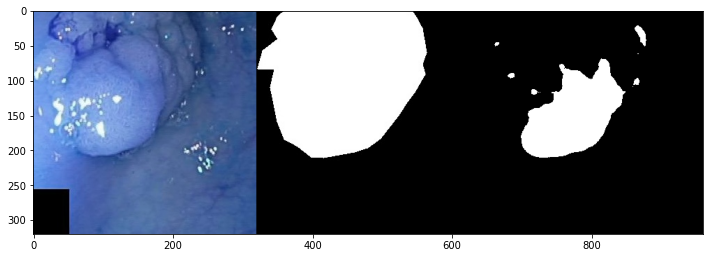

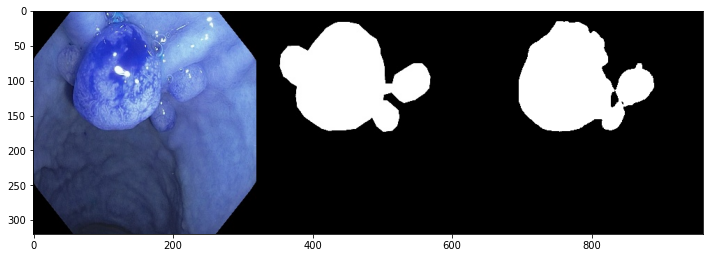

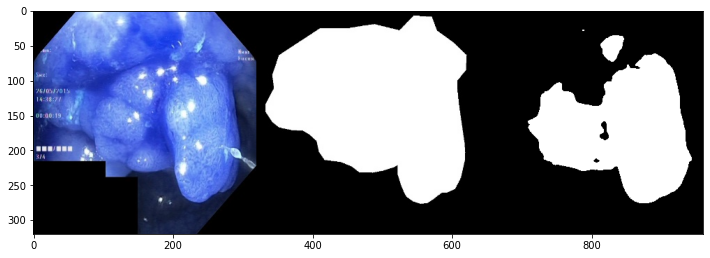

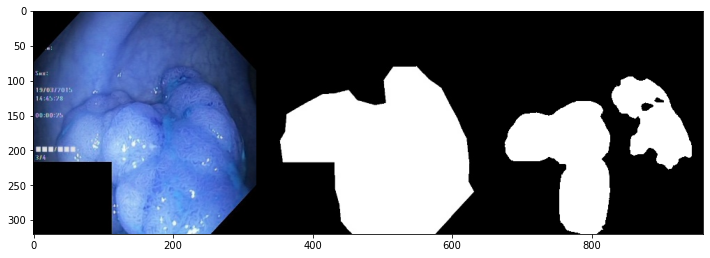

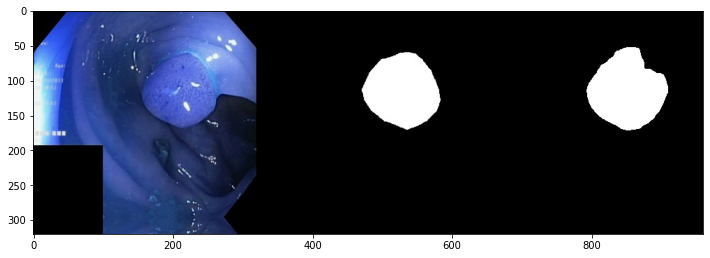

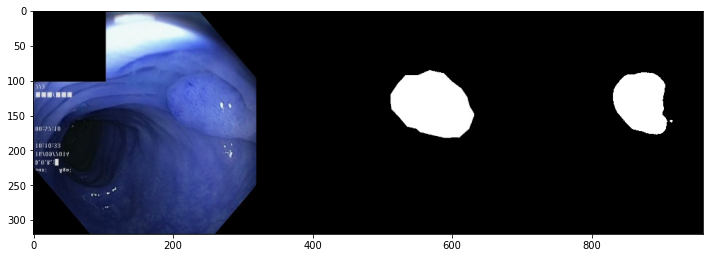

In [471]:
for i, (x, y) in enumerate(zip(X_test[:10], y_test[:10])):
    x = read_img(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    #y_pred = y_pred[0] > 0.5
    h, w, _ = x.shape
    # white_line = np.ones((h, 10, 3)) 

    all_images = [
        x,
        mask_parse(y),
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
  
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image, 'gray')